# Machine Learning LAB 3: LINEAR REGRESSION

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:
idx    | frame size (B) |  time (s)
0      | 38424          |  0.0
1      | 39801          |  0.01944
...

The game was run at 60 frames per second, with a target rate of 30 Mb/s. The task is then to **predict the size of the next frame, given the past N frames**. This was explored in another paper:

Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [55]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')

## Prepare the data and create training and test sets

In this case, we are learning a time series: let us consider a memory of **2 samples**, i.e., use X[n-1] and X[n-2] to predict X[n].

In [56]:
# Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size

# Compute the splits and prepare the columns
m_training = int(0.75*norm_data.shape[0])

X_training = np.ones([m_training - 2, 3]) # 1
X_training[:,1] = norm_data[: m_training - 2] # X[n-1]
X_training[:,2] = norm_data[1 : m_training - 1] # X[n-2]
Y_training = norm_data[2 : m_training]


X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print(np.shape(X_training), np.shape(Y_training), np.shape(X_test), np.shape(Y_test))

(25878, 3) (25878,) (8625, 3) (8625,)


## Least Squares linear regression

Train and evaluate the LS regressor on the data

*Note:* $Y = (w_0, w_1, w_2) * (1,\, X[n-1],\, X[n-2])^T$

In [57]:
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    ## TODO: Run the LS algorithm without regularization
    A = np.matmul(X_matrix.T, X_matrix)
    b = np.matmul(X_matrix.T, labels)
    if not np.any(np.isclose(np.linalg.det(A), 0)):
        w_array = np.matmul(np.linalg.inv(A), b)
        return w_array
    else:
        raise ValueError("A is not invertible.")

def evaluate_model(x, y, coeff):
    ## TODO: Return the average MSE for the set over which we evaluate
    y_predict = np.dot(coeff, x.T)
    mse = np.mean((y_predict - y)**2)
    return mse

In [58]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('Root MSE:', np.sqrt(mse) * avg_size)

Model coefficients: [0.36986742 0.20348677 0.42565451]
Root MSE: 7712.35472153933


---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$

*Note: I use the formula $\frac{\lambda}{2}||\vec{w}||^2$ for the regularization term. It may differ from the formula used by professor by a factor $2$.*

*Also, and more importantly, the values indicated by professor are to be interpreted as* **normalized** *to the sample size (i.e. not $\lambda$, but $\lambda \cdot m$).*

In [59]:
# Least squares solution
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray) -> None:
    ## TODO: Run the LS algorithm with regularization
    m = X_matrix.shape[0]
    d = X_matrix.shape[1]
    A = np.matmul(X_matrix.T, X_matrix) + lambda_par * m * np.eye(d)
    b = np.matmul(X_matrix.T, labels)
    if not np.any(np.isclose(np.linalg.det(A), 0)):
        w_array = np.matmul(np.linalg.inv(A), b)
        return w_array
    else:
        raise ValueError("A is not invertible.")
    
    
def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> None:
    ## TODO: Perform K-fold cross-validation
    shuffled_idxs = np.arange(X_training.shape[0])
    np.random.shuffle(shuffled_idxs)
    vfolds_idxs = np.array_split(shuffled_idxs, K)
    tfolds_idxs = [np.setdiff1d(shuffled_idxs, vfolds_idxs[k]) for k in range(K)]

    models = []
    results = [] # (avg, std)
    best_model = np.zeros(X_training.shape[1])
    best_perf = 10e9

    for lambda_par in lambda_vec:
        vfold_losses = []
        for k in range(K):
            xt_fold, yt_fold = X_training[tfolds_idxs[k], :], Y_training[tfolds_idxs[k]]
            xv_fold, yv_fold = X_training[vfolds_idxs[k], :], Y_training[vfolds_idxs[k]]
            model = regularized_least_squares(xt_fold, yt_fold, lambda_par)
            vfold_losses.append(evaluate_model(xv_fold, yv_fold, model))
        results.append(np.mean(vfold_losses))
        models.append(regularized_least_squares(X_training, Y_training, lambda_par))

    best_perf = np.min(results)
    #best_lambda_par = lambda_vec[np.argmin(avg_loss)]
    best_model = models[np.argmin(results)]
    return best_model, best_perf, models, results

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1215/965026177.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


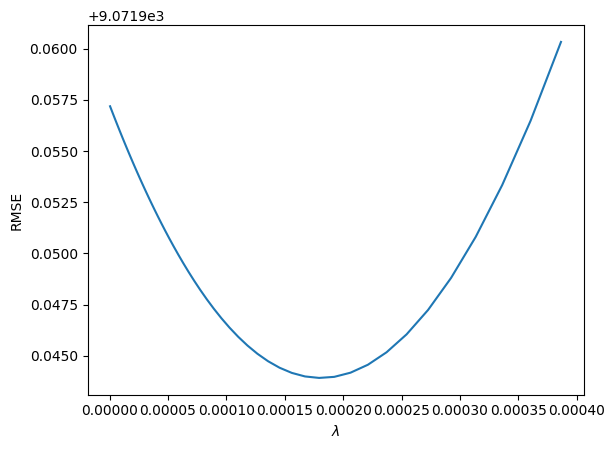

In [60]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = np.power(10*np.ones(100), np.linspace(-2, +1, 100)) / X_training.shape[0]

best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par, K)
#print(best_model, results)
plt.plot(lambda_par, np.sqrt(results) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

plt.show()


<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1215/1799133235.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


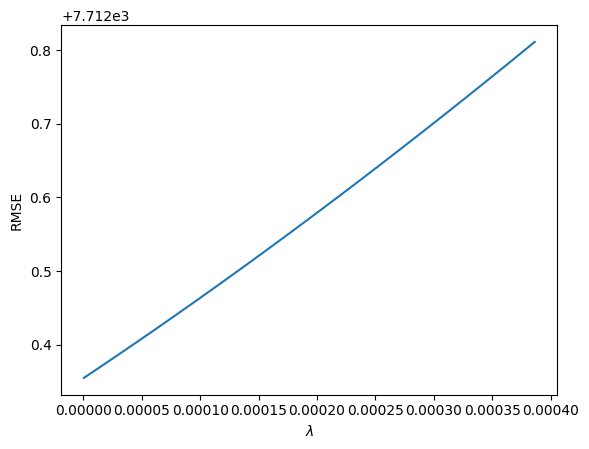

In [61]:
# Plot the results for the regularized models on the test set
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])

plt.plot(lambda_par, np.sqrt(test_scores) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


### EXTRA

Can you figure out the best amount of memory to use?


*Answer*

*The meaning of the question is:* can you figure out the best amount of **memory** *(number of past frames)* to use *(in order to predict the next frame)?

- *from a machine learning persective: perform another k-fold-cross-validation: increase number of samples (from $2$ to $3$, $4$ etc) to choose the best model, then test the performance on the test set.*

- *from another perspective: plot the average autocorrelation function of the frame size $\mathbb{E}[F(t) \cdot F(t+ T)]$ versus the log $T$. If you see that it decays after $2$ frames, there is no point in considering more thant that.*

- *a perspective that encapsulates both: do the OSL (Ordinary Least Squares) regression for a different number of past frames, then plot the autocorrelation function of the residuals. If you see autocorrelation, it means that there is some pattern in your data that your regression model was not able to exploit. Instead if autocorrelations drops to zero very fast, you are ok.*

See the lecture recording for more.

*My notes: notice that we found a test loss that is smaller than the training loss. This can happen, because both the training loss and the test loss are just estimates of the true loss, but it is unusual - the training loss tends to be smaller, as the algorithm saw the training points. In this dataset, this is likely happening because the first slice of the timeseries that we are analyzing contains a lot of big outliers - and they all end up in the training set, since we are not shuffling data before separating. If we shuffled data and/or eliminate outliers, probably the test loss will be higher than the training loss.*

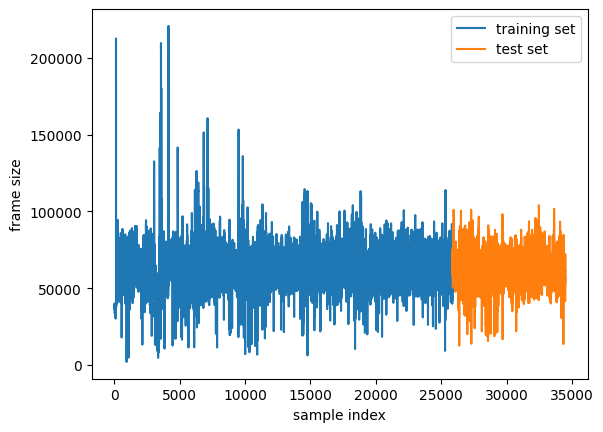

In [62]:
m_train = X_training.shape[0]
plt.plot(range(m_train), Y_training[:] * avg_size, label = 'training set')
m = m_train + X_test.shape[0]
plt.plot(range(m_train, m), Y_test[:] * avg_size, label= 'test set')
plt.xlabel('sample index')
plt.ylabel('frame size')
plt.legend()